## Imports

In [124]:
# Activate project enviroment 
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\Herbert\Documents\GitHub\AMO_Project`
┌ Warning: The project dependencies or compat requirements have changed since the manifest was last resolved.
│ It is recommended to `Pkg.resolve()` or consider `Pkg.update()` if necessary.
└ @ Pkg.API C:\workdir\usr\share\julia\stdlib\v1.8\Pkg\src\API.jl:1535


In [125]:
# die pakete die wir für dieses Notebook brauchen
using JuMP
using Plots
using XLSX
using DataFrames
using Complementarity
using Ipopt
using Distributions
using CSV
using HiGHS
using StatsPlots

## Deterministic Market Clearing Formulation 

For our market clearing optimization problem we use the 24-bus system provided in Ilias. We do not consider line constraints. The model then consists of 12 conventional generators, 4 wind farms and 17 demands (see table below). For now, we consider the demands fixed, with a curtailment cost of 500. Thus, uncertainty only comes from wind energy of the 4 wind farms. In later work, it would make sense to increase the share of wind enery in the system by some percentage and compare results or to introduce flexible demands.

In order to analyze benefits of stochastic market clearing, we first need to formulate a deterministic market clearing model. To achieve realistic wind energy distributions for each wind farm and each hour we use the data set from https://sites.google.com/site/datasmopf/wind-scenarios. The dataset holds 100 scenarios of wind power output for 15 zones over 43 hours in hourly granularity (100 wind scenarios for each hour for each zone). The scenario values are normalized between 0 and 1. We will NOT be using the given scenarios directly to predict energy output, but rather fit Weibull distributions to the scenarios to be able to generate our own scenarios via Monte Carlo method.

While we don't need the distributions for the deterministic setting, we would like to use the mean of the distributions as the single value energy prediction in the determinstic setting to ensure comparability. Thus, in the first step, we fit the Weibull distributions to the scenarios (each hour of each wind farm has it's own independent distribution). To get actual wind energy values from the normalized scenarios, we consider the given energy forcast for each wind farm (see table) as the mean of the energy production level over all 43 hours. (i.e. if the mean value of the scenarios would be 0.5 and the energy forcast is 100, we get a factor of 200)

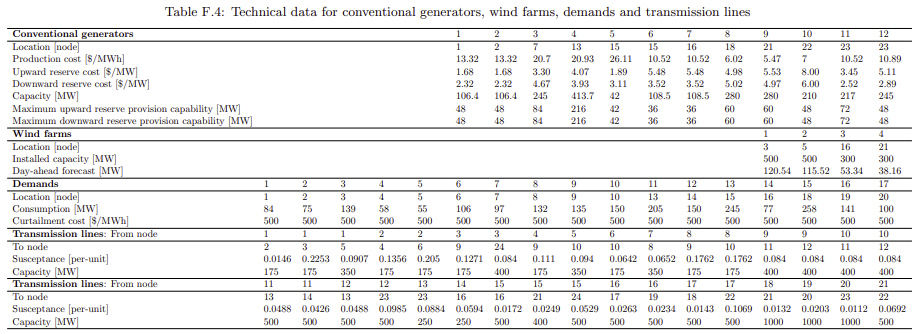

In [126]:
display("image/png", read("./resources/Model_table.PNG"))

In [127]:
# read in wind data for the aggregated zones 1-4 corresponding to the wind farms 1-4 and remove fist coloum as it contains redundant index.
scenarios = [CSV.read("./data/aggr_zone1.csv", DataFrame),CSV.read("./data/aggr_zone2.csv", DataFrame),CSV.read("./data/aggr_zone3.csv", DataFrame),CSV.read("./data/aggr_zone4.csv", DataFrame)]
c = 1
for i in scenarios
    scenarios[c]= i[:,2:end]
    c = c+1
end
size(scenarios[1])


(43, 100)

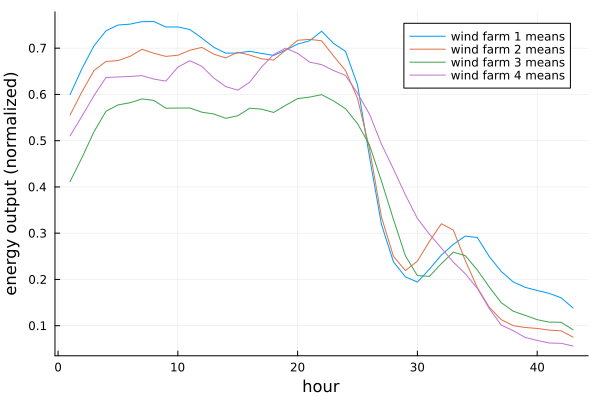

In [128]:
means = [mean.(eachrow(df)) for df in scenarios]

plot(collect(1:43),means[1],label = "wind farm 1 means", xlabel = "hour", ylabel = "energy output (normalized)")
plot!(collect(1:43),means[2],label = "wind farm 2 means")
plot!(collect(1:43),means[3],label = "wind farm 3 means")
plot!(collect(1:43),means[4],label = "wind farm 4 means")


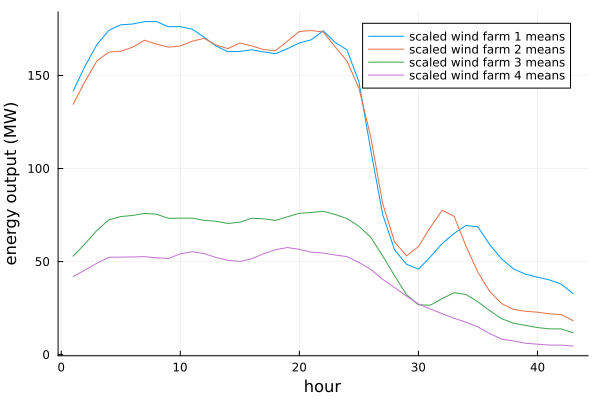

In [129]:
# scale the data to fit our model (set the predicted output to the mean of all scenarios)

forecast = [120.54, 115.52, 53.34, 38.16]

function getMean(df)
    return mean(mean.(eachrow(df)))
end

counter = 1
for s in scenarios
    factor = forecast[counter]/getMean(s)
    transform!(s,x -> x .* factor)
    counter = counter + 1
end
means_scaled = [mean.(eachrow(df)) for df in scenarios]
plot(collect(1:43),means_scaled[1],label = "scaled wind farm 1 means", xlabel = "hour", ylabel = "energy output (MW)")
plot!(collect(1:43),means_scaled[2],label = "scaled wind farm 2 means")
plot!(collect(1:43),means_scaled[3],label = "scaled wind farm 3 means")
plot!(collect(1:43),means_scaled[4],label = "scaled wind farm 4 means")

In [130]:
#Transform wind data to a 4-length array for each hour
wind_data = [[means_scaled[1][i],means_scaled[2][i],means_scaled[3][i],means_scaled[4][i]] for i in 1:43]

43-element Vector{Vector{Float64}}:
 [141.59886184139646, 134.4901277271121, 52.887060815283874, 41.93778698443961]
 [154.99472635643275, 146.76493208533861, 59.57215126128381, 45.4656994443143]
 [166.5511402500101, 157.82188152240317, 66.74076665353583, 49.08321466939806]
 [174.21747614717333, 162.52919286385338, 72.41579630309539, 52.30571906600432]
 [177.1612899681567, 162.99562482626305, 74.17726993692025, 52.39048760259822]
 [177.6077613863385, 165.17985087578847, 74.77330625883339, 52.48475510953833]
 [178.8869846913636, 168.8962760100685, 75.84407104838368, 52.62791077661087]
 [178.94046408247274, 166.82380067730904, 75.42750100427794, 52.018358276647724]
 [176.15879551528892, 165.18776537837883, 73.25195054255708, 51.65966723657585]
 [176.1907303389255, 165.77332103249788, 73.30969885702785, 54.14081249585601]
 [174.86891321550218, 168.38633946244573, 73.31877456347475, 55.27895410669029]
 [170.52792925371793, 169.90474375938916, 72.1607339181225, 54.293168459057654]
 [165.7883

In [131]:
function solveModel(t::Int,data)
    m = Model(HiGHS.Optimizer)
    print(data[:pred][t][1])
    @variable(m, 0 <= PG[k in data[:K]] <= data[:Pmax][k]) # Power output of Generators
    @variable(m, 0 <= L[l in data[:L]] <= data[:D][l]) # consumed Loads
    @variable(m, 0 <= PW[w in data[:W]] <= data[:pred][t][w]) # Power output of Windfarm --> max is prediction value
    @variable(m, 0 <= Ru[k in data[:K]] <= data[:Rmax][k]) # Upward schelduled Reserve for each Generator
    @variable(m, 0 <= Rd[k in data[:K]] <= data[:Rmax][k]) # Downward scheduled Reserve for each Generator
    @variable(m,0 <= Wspill[w in data[:W]] <= data[:pred][t][w]) # Wind spillage (no cost)
    @variable(m, 0 <= Lshed) # Load shedding

    @constraint(m,λ, sum(PG) + sum(PW) + Lshed - sum(L) - sum(Wspill) == 0) # balancing energy
    @constraint(m,sum(L)+ Lshed == sum(data[:D])) # all loads + curtailment = sum of Demand
    @constraint(m, uRmax[k in data[:K]], PG[k] + Ru[k] <= data[:Pmax][k]) # Upward reserve + Poweroutput <= Max Capacity
    @constraint(m, dRmax[k in data[:K]], PG[k] - Rd[k] >= 0) # Poweroutput - Downward reserve >= 0
    @constraint(m, α,  sum(Ru) == data[:R]) # Upward reserve == 5% of Demand
    @constraint(m,γ, sum(Rd) == data[:R]) # downward reserve == 5% of Demand

    @objective(m,Min, sum(data[:C][i]*PG[i] for i in data[:K]) + sum(data[:Cu][i]*Ru[i] + data[:Cd][i]*Rd[i] for i in data[:K]) + data[:vLOL]*Lshed)

    JuMP.optimize!(m)

    return Dict(:objective_value => objective_value(m),
    :generator_values => [value(PG[k]) for k in data[:K]],
    :load_values => [value(L[k]) for k in data[:L]],
    :wind_values => [value(PW[k]) for k in data[:W]],
    :shadow_prices => -1 * shadow_price(λ),
    :Ureserve_prices => -1 *shadow_price(α),
    :Dreserve_prices => -1 *shadow_price(γ),
    :Wspills => [value(Wspill[k]) for k in data[:W]],
    :Lshed => value(Lshed),
    :Ureserve => [value(Ru[k]) for k in data[:K]],
    :Dreserve => [value(Rd[k]) for k in data[:K]])
end

solveModel (generic function with 1 method)

In [132]:
data = Dict(
    :W => 1:4, # Wind farm index
    :K => 1:12, # Generator index
    :L => 1:17, # Load index
    :C => [99,137,151,175,183,59.5,42,64,60.2,79,58,108], # Generator Energy cost
    :Cu => [1.68,1.68,3.30,4.07,1.89,5.48,5.48,4.98,5.53,8.00,3.45,5.11], # Generator upward reserve cost
    :Cd => [2.32,2.32,4.67,3.93,3.11,3.52,3.52,5.02,4.97,6.00,2.52,2.89], # Generator downward reserve cost
    :Rmax => [48,48,84,216,42,36,36,60,60,48,72,48], # Generator reserve capacity (both up and down)
    :Pmax => [106.4,106.4,245,413.7,42,108.5,108.5,280,280,210,217,245], # Generator max Capacity
    :Wmax =>[500,500,300,300], # Wind farm max capacity
    :D =>[84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100], # Demand energy
    :vLOL => 500.0, # value of lost load
    :pred => wind_data, # wind farm output predictions [43 h]
    :R => 0.05 * sum([84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100]) # Reserve volume
)

resultsDf = DataFrame(objective = Float64[], sum_generators = Float64[], sum_loads = Float64[],
    sum_wind = Float64[], price = Float64[], URprice = Float64[], DRprice = Float64[], Wspill = Float64[],
    Lshed = Float64[])

generator_data = []
UReserve_data = []
DReserve_data =[]

for i in 1:43
    results = solveModel(i,data)
    push!(generator_data,results[:generator_values])
    push!(UReserve_data,results[:Ureserve])
    push!(DReserve_data,results[:Dreserve])
    push!(resultsDf,[results[:objective_value],sum(results[:generator_values]),sum(results[:generator_values]),sum(results[:wind_values]),results[:shadow_prices],results[:Ureserve_prices],results[:Dreserve_prices],sum(results[:Wspills]),results[:Lshed]])
end
CSV.write("./data/results/deterministic.csv",  resultsDf)

141.59886184139646Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
28 rows, 62 cols, 128 nonzeros
27 rows, 38 cols, 86 nonzeros
26 rows, 37 cols, 96 nonzeros
Presolve : Reductions: rows 26(-2); columns 37(-25); elements 96(-32)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          4     1.5341617756e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 4
Objective value     :  1.5341617756e+05
HiGHS run time      :          0.00
154.99472635643275Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
28 rows, 62 cols, 128 nonzeros
27 rows, 38 cols, 86 nonzeros
26 rows, 37 cols, 96 nonzeros
Presolve : Reductions: rows 26(-2); columns 37(-25)

"./data/results/deterministic.csv"

In [133]:
Base.displaysize() = (100, 80)
resultsDf

Row,objective,sum_generators,sum_loads,sum_wind,price,URprice,DRprice,Wspill,Lshed
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.53416e5,1836.09,1836.09,370.914,151.0,3.3,2.52,0.0,-0.0
2,1.47998e5,1800.2,1800.2,406.798,151.0,3.3,2.52,0.0,-0.0
3,1.42954e5,1766.8,1766.8,440.197,151.0,3.3,2.52,0.0,-0.0
4,1.39742e5,1745.53,1745.53,461.468,151.0,3.3,2.52,0.0,-0.0
5,1.38949e5,1740.28,1740.28,466.725,151.0,3.3,2.52,0.0,-0.0
6,1.38447e5,1736.95,1736.95,470.046,151.0,3.3,2.52,0.0,-0.0
7,1.3751e5,1730.74,1730.74,476.255,151.0,3.3,2.52,0.0,-0.0
8,1.37969e5,1733.79,1733.79,473.21,151.0,3.3,2.52,0.0,-0.0
9,1.39019e5,1740.74,1740.74,466.258,151.0,3.3,2.52,0.0,-0.0


## Results

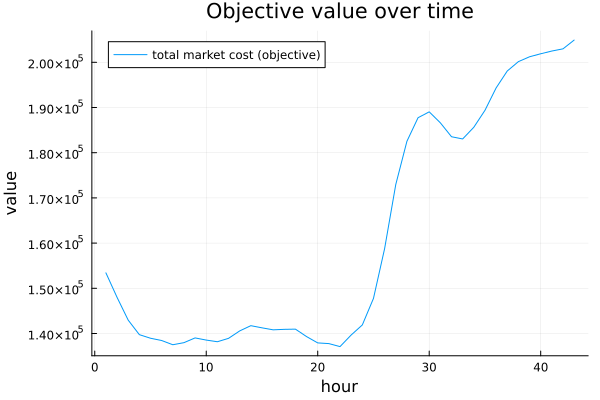

In [134]:
plot(collect(1:43),resultsDf.objective ,label = "total market cost (objective)", xlabel = "hour", ylabel = "value",title="Objective value over time")

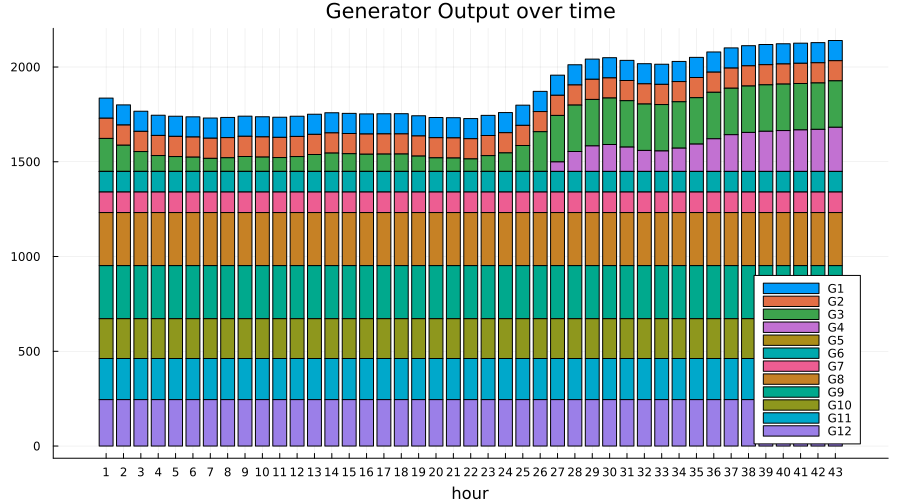

In [135]:
gen_data_pretty = [[generator_data[i][k] for i in 1:43] for k in 1:12]
groupedbar(hcat(gen_data_pretty...) , bar_position = :stack ,xticks = (1:43,1:43),size=(900,500),xlabel = "hour",
    label = permutedims(hcat(["G" * string(i) for i in 1:12])),title = "Generator Output over time",legend =:bottomright )

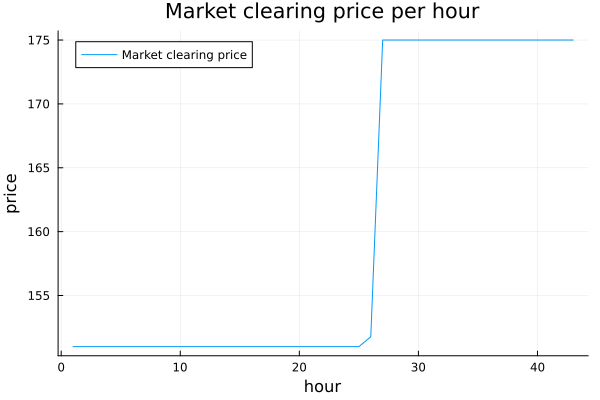

In [136]:
plot(collect(1:43),resultsDf.price ,label = "Market clearing price", xlabel = "hour", ylabel = "price",title="Market clearing price per hour")

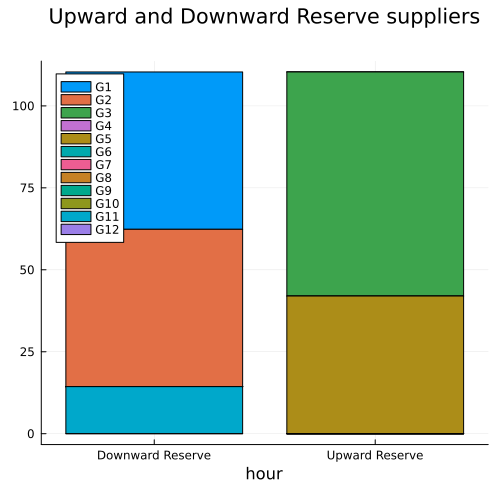

In [137]:
Reserves = [[DReserve_data[1][k] for k in 1:12],[UReserve_data[1][k] for k in 1:12]]
groupedbar(permutedims(hcat(Reserves...)) , bar_position = :stack ,xticks=([1,2],["Downward Reserve","Upward Reserve"]),size=(500,500),xlabel = "hour",
    label = permutedims(hcat(["G" * string(i) for i in 1:12])),title = "Upward and Downward Reserve suppliers
    ", )

## Increasing Wind output
Next, we double the energy produced by the wind farms to analyze its effect on the market clearing price.

In [138]:
data_doubleWind = Dict(
    :W => 1:4, # Wind farm index
    :K => 1:12, # Generator index
    :L => 1:17, # Load index
    :C => [99,137,151,175,183,59.5,42,64,60.2,79,58,108], # Generator Energy cost
    :Cu => [1.68,1.68,3.30,4.07,1.89,5.48,5.48,4.98,5.53,8.00,3.45,5.11], # Generator upward reserve cost
    :Cd => [2.32,2.32,4.67,3.93,3.11,3.52,3.52,5.02,4.97,6.00,2.52,2.89], # Generator downward reserve cost
    :Rmax => [48,48,84,216,42,36,36,60,60,48,72,48], # Generator reserve capacity (both up and down)
    :Pmax => [106.4,106.4,245,413.7,42,108.5,108.5,280,280,210,217,245], # Generator max Capacity
    :Wmax =>[500,500,300,300], # Wind farm max capacity
    :D =>[84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100], # Demand energy
    :vLOL => 500.0, # value of lost load
    :pred => wind_data, # wind farm output predictions [43 h]
    :R => 0.1 * sum([84,75,139,58,55,106,97,132,135,150,205,150,245,77,258,141,100]) # Reserve volume
)

data_doubleWind[:pred] = data_doubleWind[:pred] .* 2

resultsDflow = DataFrame(objective = Float64[], sum_generators = Float64[], sum_loads = Float64[],
    sum_wind = Float64[], price = Float64[], URprice = Float64[], DRprice = Float64[], Wspill = Float64[],
    Lshed = Float64[])

generator_data = []
UReserve_data = []
DReserve_data =[]

for i in 1:43
    results = solveModel(i,data_doubleWind)
    push!(generator_data,results[:generator_values])
    push!(UReserve_data,results[:Ureserve])
    push!(DReserve_data,results[:Dreserve])
    push!(resultsDflow,[results[:objective_value],sum(results[:generator_values]),sum(results[:generator_values]),sum(results[:wind_values]),results[:shadow_prices],results[:Ureserve_prices],results[:Dreserve_prices],sum(results[:Wspills]),results[:Lshed]])
end

283.1977236827929Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
28 rows, 62 cols, 128 nonzeros
27 rows, 38 cols, 86 nonzeros
26 rows, 37 cols, 96 nonzeros
Presolve : Reductions: rows 26(-2); columns 37(-25); elements 96(-32)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          7     1.0345807413e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 7
Objective value     :  1.0345807413e+05
HiGHS run time      :          0.00
309.9894527128655Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
28 rows, 62 cols, 128 nonzeros
27 rows, 38 cols, 86 nonzeros
26 rows, 37 cols, 96 nonzeros
Presolve : Reductions: rows 26(-2); columns 37(-25); 

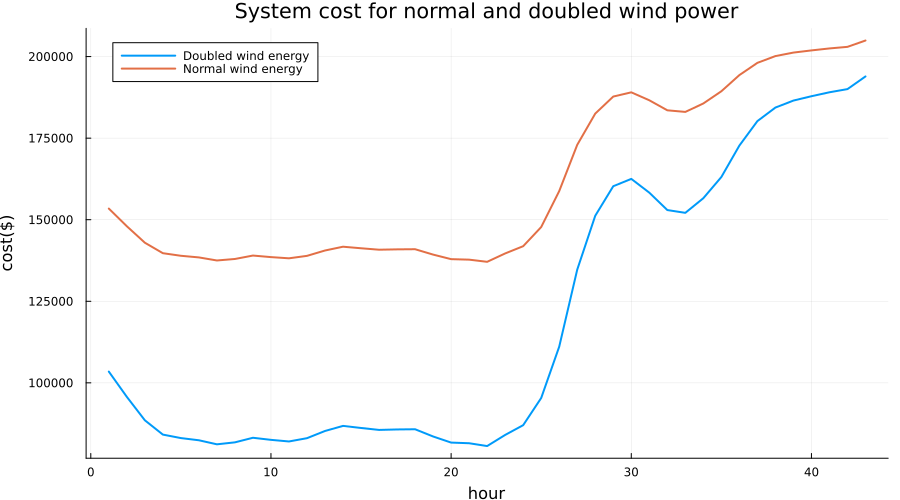

In [152]:
plot(collect(1:43),resultsDflow.objective ,label = "Doubled wind energy", xlabel = "hour", ylabel = "cost(\$)",title="System cost for normal and doubled wind power",formatter = :plain,left_margin=2Plots.mm, size=(900,500),lw=2)
plot!(collect(1:43),resultsDf.objective ,label = "Normal wind energy",lw = 2)

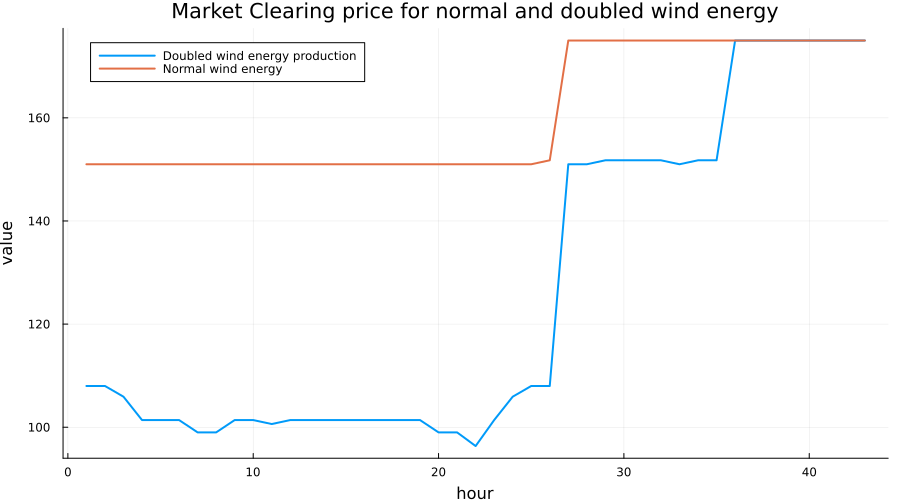

In [150]:
plot(collect(1:43),resultsDflow.price ,label = "Doubled wind energy production", xlabel = "hour", ylabel = "price(\$ per MWh)",title="Market Clearing price for normal and doubled wind energy",formatter = :plain,left_margin=2Plots.mm, size =(900,500),lw=2)
plot!(collect(1:43),resultsDf.price ,label = "Normal wind energy",lw= 2)

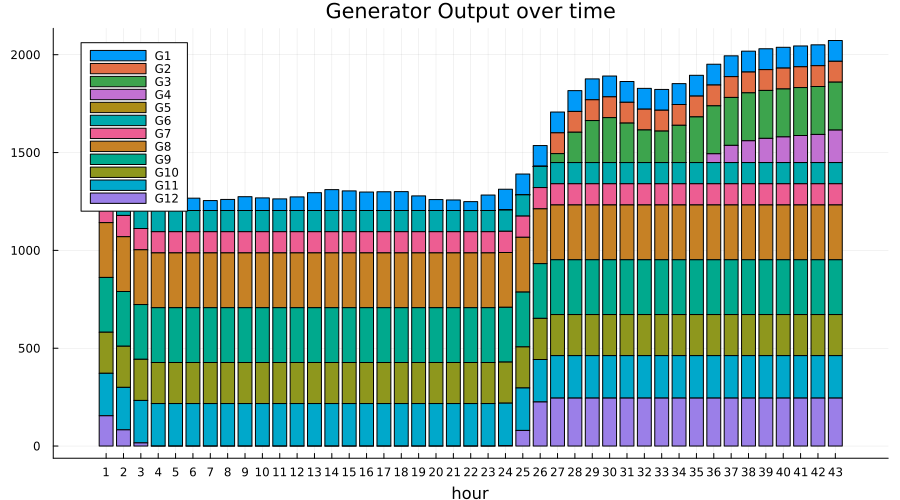

In [141]:
gen_data_pretty = [[generator_data[i][k] for i in 1:43] for k in 1:12]
groupedbar(hcat(gen_data_pretty...) , bar_position = :stack ,xticks = (1:43,1:43),size=(900,500),xlabel = "hour",
    label = permutedims(hcat(["G" * string(i) for i in 1:12])),title = "Generator Output over time", )

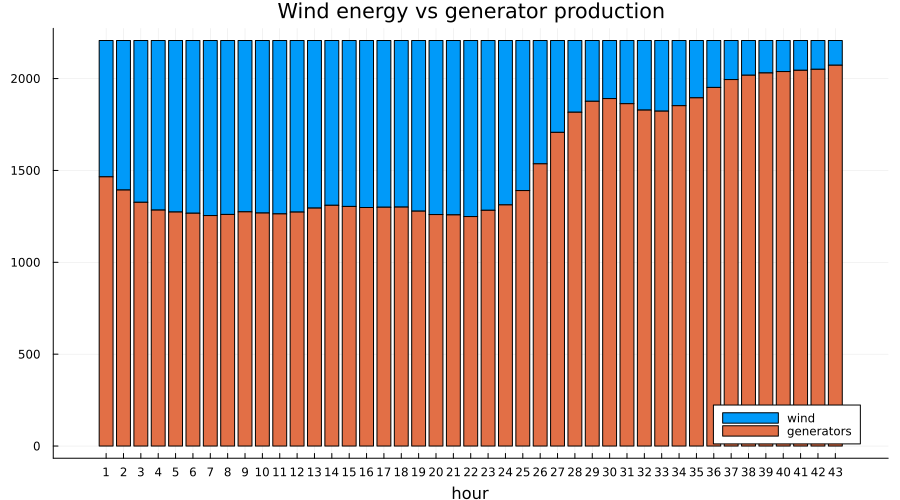

In [142]:
df1=Matrix(resultsDflow[:,[:sum_wind,:sum_generators]])
groupedbar(df1, bar_position = :stack ,xticks = (1:43,1:43),size=(900,500),xlabel = "hour",
    label = permutedims(hcat(["G" * string(i) for i in 1:12])),title = "Wind energy vs generator production", labels = ["wind" "generators"] )